In [1]:
from vip_hci.fits import open_fits
from vip_hci.var import frame_center, get_annulus_segments
from vip_hci.fm import normalize_psf
from utils import pixels_in_annulus
from norm_lowrank import norm_low_rank
from hciplot import plot_frames
import numpy as np
from vip_hci.fm.fakecomp import cube_inject_companions
from vip_hci.preproc import cube_crop_frames
import sys
# setting path
sys.path.append('..')
from likelihood_source import likelihoodmap

In [2]:
test_set_empty = 'sphere_irdis_empty' 
test_no = '3'
test_set = 'sphere_irdis'

In [3]:
datpath = '/home/daglayansevi/mc_vip_package/datasets/subchallenge_1/'
cubename = datpath+'{}_cube_{}.fits'.format(test_set_empty, test_no)
psfname = datpath+'{}_psf_{}.fits'.format(test_set, test_no)
angname = datpath+'{}_pa_{}.fits'.format(test_set, test_no)

In [4]:
cube, header_cube = open_fits(cubename, header=True)
psf = open_fits(psfname)
derot_angles = open_fits(angname)
derot_angles = -derot_angles

Fits HDU-0 data and header successfully loaded. Data shape: (228, 160, 160)
Fits HDU-0 data successfully loaded. Data shape: (41, 41)
Fits HDU-0 data successfully loaded. Data shape: (228,)


In [5]:
cube = cube_crop_frames(cube, 100, xy=None, force=False, verbose=True,
                full_output=False)

New shape: (228, 100, 100)


In [6]:
psfn, flux_st, fwhm = normalize_psf(psf, fwhm='fit', full_output=True, size=10)

`Force_odd` is True therefore `size` was set to 11

Mean FWHM: 3.922
Flux in 1xFWHM aperture: 0.998


In [7]:
cy, cx = frame_center(cube)
print('Centre of the image frame:', cy,',', cx)

Centre of the image frame: 50 , 50


In [8]:
nfr, m, n = cube.shape 

In [9]:
for rank in [9]: # we also tried rank ={13, 17, 21}
    for inner_r in [9]: # we also tried inner_r = 3
        for norm in [1]: #try also for norm=2
            lrmaps_l1 = np.zeros((25,m,n))
            #lrmaps_l2 = np.zeros((25,m,n))
            all_pos_yxs = []
            for i, th in enumerate(range(0, 900, 36)):

                pos_yxs = []
                outer = (inner_r+2)*fwhm 
                inner = inner_r*fwhm 
                width = outer - inner
                yy, xx = get_annulus_segments(cube[0], inner_r*fwhm, width)[0]
                matrix_segm = cube[:, yy, xx]
                flux = np.std(matrix_segm)*0.5
                print("The intensity of injected fluxes: ", flux) 
                dist = (inner + outer)/2
                cubefc, pos_yx = cube_inject_companions(cube, psfn, derot_angles, 
                                                            flevel=flux, plsc=0.0272, 
                                                            rad_dists=[dist], n_branches=1, 
                                                            theta=th/10.0, verbose=True, full_output=True)
                pos_yxs.append(pos_yx)
                
                cubefc, pos_yx = cube_inject_companions(cubefc, psfn, derot_angles, 
                                                            flevel=flux, plsc=0.0272, 
                                                            rad_dists=[dist], n_branches=1, 
                                                            theta=(th+900)/10.0, verbose=True, full_output=True)
                pos_yxs.append(pos_yx)
                
                cubefc, pos_yx = cube_inject_companions(cubefc, psfn, derot_angles, 
                                                            flevel=flux, plsc=0.0272, 
                                                            rad_dists=[dist], n_branches=1, 
                                                            theta=(th+1800)/10.0, verbose=True, full_output=True)
                pos_yxs.append(pos_yx)
                
                cubefc, pos_yx = cube_inject_companions(cubefc, psfn, derot_angles, 
                                                            flevel=flux, plsc=0.0272, 
                                                            rad_dists=[dist], n_branches=1, 
                                                            theta=(th+2700)/10.0, verbose=True, full_output=True)
                pos_yxs.append(pos_yx)
                
                all_pos_yxs.append(pos_yxs)

                #plot_frames(cubefc[0], circle= tuple((yx[0][1],yx[0][0]) for yx in pos_yxs), circle_radius=fwhm)


                pixels = pixels_in_annulus(cube[0].shape, (cy,cx), 6, 48)
                

                planet_position = zip(pos_yxs)

                res_cube = np.zeros_like(cube)
                res = norm_low_rank(cubefc, derot_angles, asize=4, ncomp=rank, norm=norm, imlib='opencv', full_output=True) 
                cube_out, cube_der, frame = res
                fluxmap_l1, loglr_map_l1 = likelihoodmap(cube_out, derot_angles, psfn, pixels, fwhm=fwhm, n_jobs=8, norm=1)
                #fluxmap_l2, loglr_map_l2 = likelihoodmap(cube_out, derot_angles, psfn, pixels, fwhm=fwhm, n_jobs=8, norm=2)

                lrmaps_l1[i] = loglr_map_l1
                #lrmaps_l2[i] = loglr_map_l2
                

            with open('lrmaps_{}_norm{}_l1_sep{}_flux05_full_rank{}.npy'.format(test_set,norm,inner_r+1,rank), 'wb') as f:
                np.save(f,lrmaps_l1)
            
            #with open('lrmaps_sphere_irdis_noise{}_l2_sep{}_flux05_full_rank{}_miter5.npy'.format(noise,inner_r,rank), 'wb') as f:
            #    np.save(f,lrmaps_l2)
            

The intensity of injected fluxes:  13.571444511413574
Branch 1:
	(X,Y)=(89.22, 50.00) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(50.00, 89.22) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(10.78, 50.00) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(50.00, 10.78) at 1.07 arcsec (39.22 pxs from center)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done 560 tasks      | elapsed:    6.8s
[Parallel(n_jobs=8)]: Done 1560 tasks      | elapsed:   15.7s
[Parallel(n_jobs=8)]: Done 2960 tasks      | elapsed:   26.5s
[Parallel(n_jobs=8)]: Done 4760 tasks      | elapsed:   42.5s
[Parallel(n_jobs=8)]: Done 6960 tasks      | elapsed:  1.0min
[Parallel(n_jobs=8)]: Done 7104 out of 7104 | elapsed:  1.0min finished


The intensity of injected fluxes:  13.571444511413574
Branch 1:
	(X,Y)=(89.14, 52.46) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(47.54, 89.14) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(10.86, 47.54) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(52.46, 10.86) at 1.07 arcsec (39.22 pxs from center)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 656 tasks      | elapsed:    6.1s
[Parallel(n_jobs=8)]: Done 1656 tasks      | elapsed:   14.6s
[Parallel(n_jobs=8)]: Done 3056 tasks      | elapsed:   26.0s
[Parallel(n_jobs=8)]: Done 4856 tasks      | elapsed:   40.7s
[Parallel(n_jobs=8)]: Done 7056 tasks      | elapsed:   57.8s
[Parallel(n_jobs=8)]: Done 7104 out of 7104 | elapsed:   58.1s finished


The intensity of injected fluxes:  13.571444511413574
Branch 1:
	(X,Y)=(88.91, 54.91) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(45.09, 88.91) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(11.09, 45.09) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(54.91, 11.09) at 1.07 arcsec (39.22 pxs from center)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 656 tasks      | elapsed:    5.4s
[Parallel(n_jobs=8)]: Done 1656 tasks      | elapsed:   13.2s
[Parallel(n_jobs=8)]: Done 3056 tasks      | elapsed:   24.1s
[Parallel(n_jobs=8)]: Done 4856 tasks      | elapsed:   38.3s
[Parallel(n_jobs=8)]: Done 7056 tasks      | elapsed:   55.5s
[Parallel(n_jobs=8)]: Done 7104 out of 7104 | elapsed:   55.8s finished


The intensity of injected fluxes:  13.571444511413574
Branch 1:
	(X,Y)=(88.52, 57.35) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(42.65, 88.52) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(11.48, 42.65) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(57.35, 11.48) at 1.07 arcsec (39.22 pxs from center)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 656 tasks      | elapsed:    5.9s
[Parallel(n_jobs=8)]: Done 1656 tasks      | elapsed:   13.9s
[Parallel(n_jobs=8)]: Done 3056 tasks      | elapsed:   25.5s
[Parallel(n_jobs=8)]: Done 4856 tasks      | elapsed:   40.3s
[Parallel(n_jobs=8)]: Done 7056 tasks      | elapsed:   58.9s
[Parallel(n_jobs=8)]: Done 7089 out of 7104 | elapsed:   59.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 7104 out of 7104 | elapsed:   59.2s finished


The intensity of injected fluxes:  13.571444511413574
Branch 1:
	(X,Y)=(87.98, 59.75) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(40.25, 87.98) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(12.02, 40.25) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(59.75, 12.02) at 1.07 arcsec (39.22 pxs from center)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 656 tasks      | elapsed:    5.6s
[Parallel(n_jobs=8)]: Done 1656 tasks      | elapsed:   13.9s
[Parallel(n_jobs=8)]: Done 3056 tasks      | elapsed:   24.4s
[Parallel(n_jobs=8)]: Done 4856 tasks      | elapsed:   37.8s
[Parallel(n_jobs=8)]: Done 7056 tasks      | elapsed:   55.1s
[Parallel(n_jobs=8)]: Done 7104 out of 7104 | elapsed:   55.5s finished


The intensity of injected fluxes:  13.571444511413574
Branch 1:
	(X,Y)=(87.30, 62.12) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(37.88, 87.30) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(12.70, 37.88) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(62.12, 12.70) at 1.07 arcsec (39.22 pxs from center)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 352 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done 852 tasks      | elapsed:    7.2s
[Parallel(n_jobs=8)]: Done 1552 tasks      | elapsed:   13.2s
[Parallel(n_jobs=8)]: Done 2452 tasks      | elapsed:   20.8s
[Parallel(n_jobs=8)]: Done 3552 tasks      | elapsed:   30.5s
[Parallel(n_jobs=8)]: Done 4852 tasks      | elapsed:   41.8s
[Parallel(n_jobs=8)]: Done 6352 tasks      | elapsed:   54.6s
[Parallel(n_jobs=8)]: Done 7104 out of 7104 | elapsed:  1.0min finished


The intensity of injected fluxes:  13.571444511413574
Branch 1:
	(X,Y)=(86.46, 64.44) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(35.56, 86.46) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(13.54, 35.56) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(64.44, 13.54) at 1.07 arcsec (39.22 pxs from center)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 656 tasks      | elapsed:    5.5s
[Parallel(n_jobs=8)]: Done 1656 tasks      | elapsed:   14.3s
[Parallel(n_jobs=8)]: Done 3056 tasks      | elapsed:   26.3s
[Parallel(n_jobs=8)]: Done 4856 tasks      | elapsed:   42.1s
[Parallel(n_jobs=8)]: Done 7056 tasks      | elapsed:  1.0min
[Parallel(n_jobs=8)]: Done 7104 out of 7104 | elapsed:  1.0min finished


The intensity of injected fluxes:  13.571444511413574
Branch 1:
	(X,Y)=(85.48, 66.70) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(33.30, 85.48) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(14.52, 33.30) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(66.70, 14.52) at 1.07 arcsec (39.22 pxs from center)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 656 tasks      | elapsed:    5.8s
[Parallel(n_jobs=8)]: Done 1656 tasks      | elapsed:   15.0s
[Parallel(n_jobs=8)]: Done 3056 tasks      | elapsed:   27.8s
[Parallel(n_jobs=8)]: Done 4856 tasks      | elapsed:   44.3s
[Parallel(n_jobs=8)]: Done 7056 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 7104 out of 7104 | elapsed:  1.1min finished


The intensity of injected fluxes:  13.571444511413574
Branch 1:
	(X,Y)=(84.36, 68.89) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(31.11, 84.36) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(15.64, 31.11) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(68.89, 15.64) at 1.07 arcsec (39.22 pxs from center)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 656 tasks      | elapsed:    5.4s
[Parallel(n_jobs=8)]: Done 1656 tasks      | elapsed:   13.3s
[Parallel(n_jobs=8)]: Done 3056 tasks      | elapsed:   24.4s
[Parallel(n_jobs=8)]: Done 4856 tasks      | elapsed:   39.0s
[Parallel(n_jobs=8)]: Done 7056 tasks      | elapsed:   55.7s
[Parallel(n_jobs=8)]: Done 7089 out of 7104 | elapsed:   55.9s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 7104 out of 7104 | elapsed:   55.9s finished


The intensity of injected fluxes:  13.571444511413574
Branch 1:
	(X,Y)=(83.11, 71.01) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(28.99, 83.11) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(16.89, 28.99) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(71.01, 16.89) at 1.07 arcsec (39.22 pxs from center)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 656 tasks      | elapsed:    5.8s
[Parallel(n_jobs=8)]: Done 1656 tasks      | elapsed:   14.5s
[Parallel(n_jobs=8)]: Done 3056 tasks      | elapsed:   26.9s
[Parallel(n_jobs=8)]: Done 4856 tasks      | elapsed:   42.5s
[Parallel(n_jobs=8)]: Done 7056 tasks      | elapsed:  1.0min
[Parallel(n_jobs=8)]: Done 7104 out of 7104 | elapsed:  1.0min finished


The intensity of injected fluxes:  13.571444511413574
Branch 1:
	(X,Y)=(81.73, 73.05) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(26.95, 81.73) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(18.27, 26.95) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(73.05, 18.27) at 1.07 arcsec (39.22 pxs from center)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 656 tasks      | elapsed:    6.2s
[Parallel(n_jobs=8)]: Done 1656 tasks      | elapsed:   15.2s
[Parallel(n_jobs=8)]: Done 3056 tasks      | elapsed:   28.1s
[Parallel(n_jobs=8)]: Done 4856 tasks      | elapsed:   43.9s
[Parallel(n_jobs=8)]: Done 7056 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 7089 out of 7104 | elapsed:  1.1min remaining:    0.1s
[Parallel(n_jobs=8)]: Done 7104 out of 7104 | elapsed:  1.1min finished


The intensity of injected fluxes:  13.571444511413574
Branch 1:
	(X,Y)=(80.22, 75.00) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(25.00, 80.22) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(19.78, 25.00) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(75.00, 19.78) at 1.07 arcsec (39.22 pxs from center)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 656 tasks      | elapsed:    6.1s
[Parallel(n_jobs=8)]: Done 1656 tasks      | elapsed:   14.6s
[Parallel(n_jobs=8)]: Done 3056 tasks      | elapsed:   26.4s
[Parallel(n_jobs=8)]: Done 4856 tasks      | elapsed:   42.3s
[Parallel(n_jobs=8)]: Done 7056 tasks      | elapsed:  1.0min
[Parallel(n_jobs=8)]: Done 7104 out of 7104 | elapsed:  1.0min finished


The intensity of injected fluxes:  13.571444511413574
Branch 1:
	(X,Y)=(78.59, 76.84) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(23.16, 78.59) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(21.41, 23.16) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(76.84, 21.41) at 1.07 arcsec (39.22 pxs from center)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 352 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done 852 tasks      | elapsed:    7.8s
[Parallel(n_jobs=8)]: Done 1552 tasks      | elapsed:   14.2s
[Parallel(n_jobs=8)]: Done 2452 tasks      | elapsed:   22.5s
[Parallel(n_jobs=8)]: Done 3552 tasks      | elapsed:   32.6s
[Parallel(n_jobs=8)]: Done 4852 tasks      | elapsed:   43.3s
[Parallel(n_jobs=8)]: Done 6352 tasks      | elapsed:   57.0s
[Parallel(n_jobs=8)]: Done 7104 out of 7104 | elapsed:  1.1min finished


The intensity of injected fluxes:  13.571444511413574
Branch 1:
	(X,Y)=(76.84, 78.59) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(21.41, 76.84) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(23.16, 21.41) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(78.59, 23.16) at 1.07 arcsec (39.22 pxs from center)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 656 tasks      | elapsed:    5.8s
[Parallel(n_jobs=8)]: Done 1656 tasks      | elapsed:   14.6s
[Parallel(n_jobs=8)]: Done 3056 tasks      | elapsed:   27.1s
[Parallel(n_jobs=8)]: Done 4856 tasks      | elapsed:   42.4s
[Parallel(n_jobs=8)]: Done 7056 tasks      | elapsed:  1.0min
[Parallel(n_jobs=8)]: Done 7104 out of 7104 | elapsed:  1.0min finished


The intensity of injected fluxes:  13.571444511413574
Branch 1:
	(X,Y)=(75.00, 80.22) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(19.78, 75.00) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(25.00, 19.78) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(80.22, 25.00) at 1.07 arcsec (39.22 pxs from center)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 656 tasks      | elapsed:    5.8s
[Parallel(n_jobs=8)]: Done 1656 tasks      | elapsed:   14.9s
[Parallel(n_jobs=8)]: Done 3056 tasks      | elapsed:   27.2s
[Parallel(n_jobs=8)]: Done 4856 tasks      | elapsed:   42.6s
[Parallel(n_jobs=8)]: Done 7056 tasks      | elapsed:  1.0min
[Parallel(n_jobs=8)]: Done 7089 out of 7104 | elapsed:  1.0min remaining:    0.1s
[Parallel(n_jobs=8)]: Done 7104 out of 7104 | elapsed:  1.0min finished


The intensity of injected fluxes:  13.571444511413574
Branch 1:
	(X,Y)=(73.05, 81.73) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(18.27, 73.05) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(26.95, 18.27) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(81.73, 26.95) at 1.07 arcsec (39.22 pxs from center)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 352 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done 852 tasks      | elapsed:    7.9s
[Parallel(n_jobs=8)]: Done 1552 tasks      | elapsed:   14.2s
[Parallel(n_jobs=8)]: Done 2452 tasks      | elapsed:   22.5s
[Parallel(n_jobs=8)]: Done 3552 tasks      | elapsed:   31.8s
[Parallel(n_jobs=8)]: Done 4852 tasks      | elapsed:   42.5s
[Parallel(n_jobs=8)]: Done 6352 tasks      | elapsed:   55.9s
[Parallel(n_jobs=8)]: Done 7104 out of 7104 | elapsed:  1.0min finished


The intensity of injected fluxes:  13.571444511413574
Branch 1:
	(X,Y)=(71.01, 83.11) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(16.89, 71.01) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(28.99, 16.89) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(83.11, 28.99) at 1.07 arcsec (39.22 pxs from center)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 656 tasks      | elapsed:    6.2s
[Parallel(n_jobs=8)]: Done 1656 tasks      | elapsed:   15.5s
[Parallel(n_jobs=8)]: Done 3056 tasks      | elapsed:   28.6s
[Parallel(n_jobs=8)]: Done 4856 tasks      | elapsed:   45.8s
[Parallel(n_jobs=8)]: Done 7056 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 7104 out of 7104 | elapsed:  1.1min finished


The intensity of injected fluxes:  13.571444511413574
Branch 1:
	(X,Y)=(68.89, 84.36) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(15.64, 68.89) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(31.11, 15.64) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(84.36, 31.11) at 1.07 arcsec (39.22 pxs from center)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 352 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done 852 tasks      | elapsed:    7.2s
[Parallel(n_jobs=8)]: Done 1552 tasks      | elapsed:   13.1s
[Parallel(n_jobs=8)]: Done 2452 tasks      | elapsed:   21.0s
[Parallel(n_jobs=8)]: Done 3552 tasks      | elapsed:   30.3s
[Parallel(n_jobs=8)]: Done 4852 tasks      | elapsed:   41.7s
[Parallel(n_jobs=8)]: Done 6352 tasks      | elapsed:   55.0s
[Parallel(n_jobs=8)]: Done 7104 out of 7104 | elapsed:  1.0min finished


The intensity of injected fluxes:  13.571444511413574
Branch 1:
	(X,Y)=(66.70, 85.48) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(14.52, 66.70) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(33.30, 14.52) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(85.48, 33.30) at 1.07 arcsec (39.22 pxs from center)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 656 tasks      | elapsed:    5.8s
[Parallel(n_jobs=8)]: Done 1656 tasks      | elapsed:   14.2s
[Parallel(n_jobs=8)]: Done 3056 tasks      | elapsed:   26.4s
[Parallel(n_jobs=8)]: Done 4856 tasks      | elapsed:   42.2s
[Parallel(n_jobs=8)]: Done 7056 tasks      | elapsed:  1.0min
[Parallel(n_jobs=8)]: Done 7089 out of 7104 | elapsed:  1.0min remaining:    0.1s
[Parallel(n_jobs=8)]: Done 7104 out of 7104 | elapsed:  1.0min finished


The intensity of injected fluxes:  13.571444511413574
Branch 1:
	(X,Y)=(64.44, 86.46) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(13.54, 64.44) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(35.56, 13.54) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(86.46, 35.56) at 1.07 arcsec (39.22 pxs from center)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 656 tasks      | elapsed:    5.8s
[Parallel(n_jobs=8)]: Done 1656 tasks      | elapsed:   14.7s
[Parallel(n_jobs=8)]: Done 3056 tasks      | elapsed:   26.7s
[Parallel(n_jobs=8)]: Done 4856 tasks      | elapsed:   42.2s
[Parallel(n_jobs=8)]: Done 7056 tasks      | elapsed:  1.0min
[Parallel(n_jobs=8)]: Done 7089 out of 7104 | elapsed:  1.0min remaining:    0.1s
[Parallel(n_jobs=8)]: Done 7104 out of 7104 | elapsed:  1.0min finished


The intensity of injected fluxes:  13.571444511413574
Branch 1:
	(X,Y)=(62.12, 87.30) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(12.70, 62.12) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(37.88, 12.70) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(87.30, 37.88) at 1.07 arcsec (39.22 pxs from center)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 656 tasks      | elapsed:    5.5s
[Parallel(n_jobs=8)]: Done 1656 tasks      | elapsed:   13.5s
[Parallel(n_jobs=8)]: Done 3056 tasks      | elapsed:   24.7s
[Parallel(n_jobs=8)]: Done 4856 tasks      | elapsed:   38.5s
[Parallel(n_jobs=8)]: Done 7056 tasks      | elapsed:   55.2s
[Parallel(n_jobs=8)]: Done 7089 out of 7104 | elapsed:   55.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 7104 out of 7104 | elapsed:   55.5s finished


The intensity of injected fluxes:  13.571444511413574
Branch 1:
	(X,Y)=(59.75, 87.98) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(12.02, 59.75) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(40.25, 12.02) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(87.98, 40.25) at 1.07 arcsec (39.22 pxs from center)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 656 tasks      | elapsed:    5.3s
[Parallel(n_jobs=8)]: Done 1656 tasks      | elapsed:   13.6s
[Parallel(n_jobs=8)]: Done 3056 tasks      | elapsed:   25.2s
[Parallel(n_jobs=8)]: Done 4856 tasks      | elapsed:   40.1s
[Parallel(n_jobs=8)]: Done 7056 tasks      | elapsed:   59.0s
[Parallel(n_jobs=8)]: Done 7089 out of 7104 | elapsed:   59.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 7104 out of 7104 | elapsed:   59.3s finished


The intensity of injected fluxes:  13.571444511413574
Branch 1:
	(X,Y)=(57.35, 88.52) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(11.48, 57.35) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(42.65, 11.48) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(88.52, 42.65) at 1.07 arcsec (39.22 pxs from center)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 656 tasks      | elapsed:    5.8s
[Parallel(n_jobs=8)]: Done 1656 tasks      | elapsed:   13.7s
[Parallel(n_jobs=8)]: Done 3056 tasks      | elapsed:   24.1s
[Parallel(n_jobs=8)]: Done 4856 tasks      | elapsed:   38.2s
[Parallel(n_jobs=8)]: Done 7056 tasks      | elapsed:   55.1s
[Parallel(n_jobs=8)]: Done 7089 out of 7104 | elapsed:   55.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 7104 out of 7104 | elapsed:   55.4s finished


The intensity of injected fluxes:  13.571444511413574
Branch 1:
	(X,Y)=(54.91, 88.91) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(11.09, 54.91) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(45.09, 11.09) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(88.91, 45.09) at 1.07 arcsec (39.22 pxs from center)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 656 tasks      | elapsed:    5.4s
[Parallel(n_jobs=8)]: Done 1656 tasks      | elapsed:   12.9s
[Parallel(n_jobs=8)]: Done 3056 tasks      | elapsed:   23.9s
[Parallel(n_jobs=8)]: Done 4856 tasks      | elapsed:   37.9s
[Parallel(n_jobs=8)]: Done 7056 tasks      | elapsed:   54.4s
[Parallel(n_jobs=8)]: Done 7104 out of 7104 | elapsed:   54.6s finished


The intensity of injected fluxes:  13.571444511413574
Branch 1:
	(X,Y)=(52.46, 89.14) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(10.86, 52.46) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(47.54, 10.86) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(89.14, 47.54) at 1.07 arcsec (39.22 pxs from center)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 656 tasks      | elapsed:    5.5s
[Parallel(n_jobs=8)]: Done 1656 tasks      | elapsed:   13.2s
[Parallel(n_jobs=8)]: Done 3056 tasks      | elapsed:   24.7s
[Parallel(n_jobs=8)]: Done 4856 tasks      | elapsed:   38.4s
[Parallel(n_jobs=8)]: Done 7056 tasks      | elapsed:   56.7s
[Parallel(n_jobs=8)]: Done 7089 out of 7104 | elapsed:   56.9s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 7104 out of 7104 | elapsed:   57.0s finished


In [9]:
for rank in [9]: # we also tried rank ={13, 17, 21}
    for inner_r in [9]: # we also tried inner_r = 3
        for norm in [1]: #try also for norm=2
            lrmaps_l1 = np.zeros((25,m,n))
            #lrmaps_l2 = np.zeros((25,m,n))
            all_pos_yxs = []
            for i, th in enumerate(range(0, 900, 36)):

                pos_yxs = []
                outer = (inner_r+2)*fwhm 
                inner = inner_r*fwhm 
                width = outer - inner
                yy, xx = get_annulus_segments(cube[0], inner_r*fwhm, width)[0]
                matrix_segm = cube[:, yy, xx]
                flux = np.std(matrix_segm)*0.5
                print("The intensity of injected fluxes: ", flux) 
                dist = (inner + outer)/2
                cubefc, pos_yx = cube_inject_companions(cube, psfn, derot_angles, 
                                                            flevel=flux, plsc=0.0272, 
                                                            rad_dists=[dist], n_branches=1, 
                                                            theta=th/10.0, verbose=True, full_output=True)
                pos_yxs.append(pos_yx)
                
                cubefc, pos_yx = cube_inject_companions(cubefc, psfn, derot_angles, 
                                                            flevel=flux, plsc=0.0272, 
                                                            rad_dists=[dist], n_branches=1, 
                                                            theta=(th+900)/10.0, verbose=True, full_output=True)
                pos_yxs.append(pos_yx)
                
                cubefc, pos_yx = cube_inject_companions(cubefc, psfn, derot_angles, 
                                                            flevel=flux, plsc=0.0272, 
                                                            rad_dists=[dist], n_branches=1, 
                                                            theta=(th+1800)/10.0, verbose=True, full_output=True)
                pos_yxs.append(pos_yx)
                
                cubefc, pos_yx = cube_inject_companions(cubefc, psfn, derot_angles, 
                                                            flevel=flux, plsc=0.0272, 
                                                            rad_dists=[dist], n_branches=1, 
                                                            theta=(th+2700)/10.0, verbose=True, full_output=True)
                pos_yxs.append(pos_yx)
                all_pos_yxs.append(pos_yxs)

The intensity of injected fluxes:  13.571444511413574
Branch 1:
	(X,Y)=(89.22, 50.00) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(50.00, 89.22) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(10.78, 50.00) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(50.00, 10.78) at 1.07 arcsec (39.22 pxs from center)
The intensity of injected fluxes:  13.571444511413574
Branch 1:
	(X,Y)=(89.14, 52.46) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(47.54, 89.14) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(10.86, 47.54) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(52.46, 10.86) at 1.07 arcsec (39.22 pxs from center)
The intensity of injected fluxes:  13.571444511413574
Branch 1:
	(X,Y)=(88.91, 54.91) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(45.09, 88.91) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(11.09, 45.09) at 1.07 arcsec (39.22 pxs from center)
Branch 1:
	(X,Y)=(54.91, 11.09) at 1.07 arcsec (39.22 pxs

In [10]:
len(all_pos_yxs[0])

4

VIP version:  1.3.0


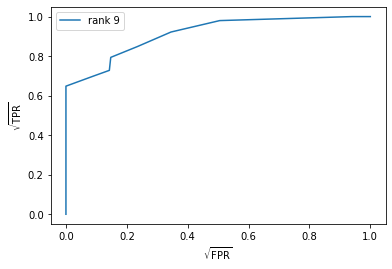

In [10]:
from build_roc_curve import build_roc_curve

with open('lrmaps_{}_norm{}_l1_sep{}_flux05_full_rank{}.npy'.format(test_set,norm,inner_r+1,rank), 'rb') as f:
    lrmaps_l1 = np.load(f) 

import matplotlib.pyplot as plt
f = plt.figure()
f = build_roc_curve(lrmaps_l1, all_pos_yxs, thresholds=None, fwhm=fwhm, sqrt=True, plot=False, vmax=30, label='rank 9', fig=f)

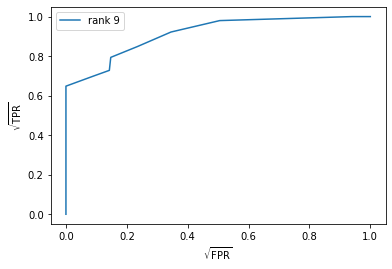

In [11]:
display(f)

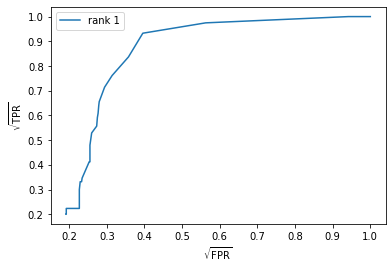

In [12]:
with open('lrmaps_sphere_irdis_norm1_l1_sep9_flux05_full_rank9_miter5.npy', 'rb') as f:
    lrmaps_l12 = np.load(f) 

f = build_roc_curve(lrmaps_l12, all_pos_yxs, thresholds=None, fwhm=fwhm, sqrt=True, plot=False, vmax=30, label='rank 1', fig=f)